### 1. Fetch the movie reviews data from Kaggle

In [1]:
import zipfile
import os
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate() # using the json file in the folder ~/.kaggle

# Download files from Kaggle and unzip them
for file in ['train.tsv', 'test.tsv']:
    api.competition_download_file('sentiment-analysis-on-movie-reviews', f'{file}.zip', path='./data')
    with zipfile.ZipFile(f'./data/{file}.zip', 'r') as zip_ref:
        zip_ref.extractall('./data')

    os.remove(f'./data/{file}.zip')


100%|██████████| 1.28M/1.28M [00:00<00:00, 4.15MB/s]


100%|██████████| 494k/494k [00:00<00:00, 2.04MB/s]

### 2. Prepare the data for Training and Validation

In [2]:
import pandas as pd

df = pd.read_csv('./data/train.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [3]:
df.shape

(156060, 4)

In [4]:
# Remove duplicates
df.drop_duplicates(subset=['SentenceId'], inplace=True, keep='first')
df.shape

(8529, 4)

<Axes: title={'center': 'Sentiment distribution'}, xlabel='Sentiment', ylabel='Count'>

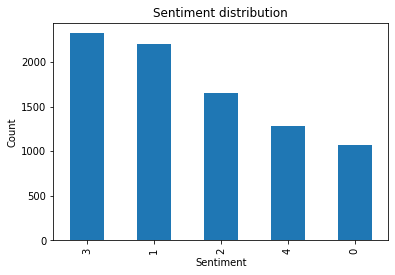

In [5]:
# get an idea of the distribution of the sentiments
df['Sentiment'].value_counts().plot(kind='bar', title='Sentiment distribution', xlabel='Sentiment', ylabel='Count')

In [6]:
# get an idea of the distribution of the length of the phrases
seq_len = df['Phrase'].apply(lambda x: len(x.split()))
seq_len.describe()

count    8529.000000
mean       18.999179
std         9.361656
min         0.000000
25%        12.000000
50%        18.000000
75%        25.000000
max        52.000000
Name: Phrase, dtype: float64

<Axes: >

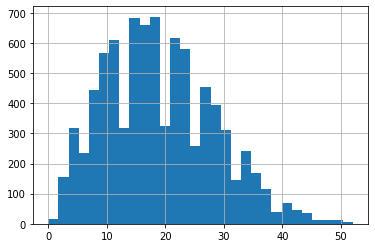

In [7]:
seq_len.hist(bins=30)

In [8]:
# Based on the above analysis, we will set the max length of the phrases to 50
MAX_SEQ_LEN = 50

In [10]:
# Tokenize the phrases to create two input tensors for the model - input ids and attention masks
from transformers import AutoTokenizer

# initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')


In [11]:
# Tokenize the phrases returning the input ids and attention masks with the max length set to 50 and padding the sequences to the max length and truncating the sequences to the max length if they are longer than 50 tokens and return the numpy arrays, avoid loading the data as a tensor into GPU memory as it will be loaded as a tensor when we create the data loader

tokens = tokenizer.__call__(df['Phrase'].tolist(), max_length=MAX_SEQ_LEN, padding='max_length', truncation=True, return_token_type_ids=False, return_attention_mask=True, add_special_tokens=True, return_tensors='np')

print(f'tokens keys: {tokens.keys()} \ntokens: {tokens}')


tokens keys: dict_keys(['input_ids', 'attention_mask']) 
tokens: {'input_ids': array([[ 101,  138, 1326, ...,    0,    0,    0],
       [ 101, 1188, 3589, ...,    0,    0,    0],
       [ 101, 2431, 3899, ...,    0,    0,    0],
       ...,
       [ 101,  118,  149, ...,    0,    0,    0],
       [ 101, 1109, 2523, ...,    0,    0,    0],
       [ 101, 1109, 1273, ...,    0,    0,    0]]), 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])}


#### Prepare the target data i.e the sentiment labels

In [12]:
# extract the sentiment column
arr = df['Sentiment'].values
arr

array([1, 4, 1, ..., 1, 1, 2], dtype=int64)

There are five values (0, 1, 2, 3, 4, 5) in the Sentiment Column.
Use one hot encoding to place a 1 in the correct postion for each row in the labels array

In [13]:
# initialize the labels numpy array
import numpy as np
labels = np.zeros((arr.size, arr.max()+1))
print(f'labels shape: {labels.shape} \nlabels: {labels}')

labels shape: (8529, 5) 
labels: [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [14]:
# Now, we will one-hot encode the labels using the current values in our arr of [0, 1, 2, 3, 4] to place 1s in the correct columns of the labels array
labels[np.arange(arr.size), arr] = 1
print(f'labels shape: {labels.shape} \nlabels: {labels}')

labels shape: (8529, 5) 
labels: [[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [15]:
tokens['input_ids']

array([[ 101,  138, 1326, ...,    0,    0,    0],
       [ 101, 1188, 3589, ...,    0,    0,    0],
       [ 101, 2431, 3899, ...,    0,    0,    0],
       ...,
       [ 101,  118,  149, ...,    0,    0,    0],
       [ 101, 1109, 2523, ...,    0,    0,    0],
       [ 101, 1109, 1273, ...,    0,    0,    0]])

In [16]:
# Save the tokens to a file for later use in the model training
# as numpy binary files

with open('./data/prepared_dataset.npz', 'wb') as f:
    np.savez(f, Xids = tokens['input_ids'], Xmask = tokens['attention_mask'], Ylabels=labels)

In [17]:
del df, tokens, labels, arr

### 3. Input data NLP pipeline

In [18]:
with open('./data/prepared_dataset.npz', 'rb') as f:
    data = np.load(f)
    Xids = data['Xids']
    Xmask = data['Xmask']
    Ylabels = data['Ylabels']

In [19]:
print(f'Xids shape: {Xids.shape} \nXids: {Xids}')
print(f'Xmask shape: {Xmask.shape} \nXmask: {Xmask}')
print(f'Ylabels shape: {Ylabels.shape} \nYlabels: {Ylabels}')

Xids shape: (8529, 50) 
Xids: [[ 101  138 1326 ...    0    0    0]
 [ 101 1188 3589 ...    0    0    0]
 [ 101 2431 3899 ...    0    0    0]
 ...
 [ 101  118  149 ...    0    0    0]
 [ 101 1109 2523 ...    0    0    0]
 [ 101 1109 1273 ...    0    0    0]]
Xmask shape: (8529, 50) 
Xmask: [[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]
Ylabels shape: (8529, 5) 
Ylabels: [[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [20]:
# Take the above three arrays and create a Tensorflow Dataset using the tf.data.Dataset.from_tensor_slices method

import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, Ylabels))
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(50,), dtype=tf.int32, name=None), TensorSpec(shape=(50,), dtype=tf.int32, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

We need to convert the dataset from a tuple containing (Xids, Xmask and Ylabels) to (inputs, outputs)

In [21]:
# rearrange the dataset format using a map function
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [22]:
dataset = dataset.map(map_func)
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(50,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(50,), dtype=tf.int32, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [23]:
# batch and shuffle the dataset
dataset = dataset.shuffle(100000).batch(32, drop_remainder=True)
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(32, 50), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(32, 50), dtype=tf.int32, name=None)}, TensorSpec(shape=(32, 5), dtype=tf.float64, name=None))>

In [24]:
# split the dataset into train and validate sets using take and skip methods. We will use 90% of the data for training and 10% for validation
split = 0.9
size = int((Xids.shape[0] / 32) * split)
size

239

In [25]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

# save the train and validate datasets to a file for later use in the model training
tf.data.Dataset.save(train_ds, './data/train_ds')
tf.data.Dataset.save(val_ds, './data/val_ds')

# free up memory
del dataset

### 4. Build the Transformer model

In [26]:
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-cased')

bert.summary()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Define the framework for the model around the BERT model
# Two input layers - input_ids and attention_mask
# Post-BERT layers - Max pooling, Normalization, Dropout, Activation, Dense
# Output layer - Dense with 5 units and softmax activation

input_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), name='attention_mask', dtype='int32')

embeddings = bert(input_ids, attention_mask=mask)[0]

X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation='relu')(X)
X = tf.keras.layers.Dropout(0.1)(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(X)

In [28]:
# initialize the model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# freeze the BERT layer
model.layers[2].trainable = False

# print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 50,                                            

In [30]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5), tf.keras.callbacks.ModelCheckpoint('./models/best_model.h5', save_best_only=True, verbose=1)]

In [31]:
# Define and initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Define the loss function
loss = tf.keras.losses.CategoricalCrossentropy()

# Define the accuracy metric
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

### 5. Compile and Train the model

In [32]:
# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [33]:
# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=callbacks)

Epoch 1/100
239/239 [==============================] - ETA: 0s - loss: 1.4791 - accuracy: 0.3546
Epoch 1: val_loss improved from inf to 1.27472, saving model to ./models\best_model.h5
239/239 [==============================] - 15s 46ms/step - loss: 1.4791 - accuracy: 0.3546 - val_loss: 1.2747 - val_accuracy: 0.4688
Epoch 2/100
239/239 [==============================] - ETA: 0s - loss: 1.3075 - accuracy: 0.4193
Epoch 2: val_loss improved from 1.27472 to 1.16942, saving model to ./models\best_model.h5
239/239 [==============================] - 10s 41ms/step - loss: 1.3075 - accuracy: 0.4193 - val_loss: 1.1694 - val_accuracy: 0.4931
Epoch 3/100
239/239 [==============================] - ETA: 0s - loss: 1.2644 - accuracy: 0.4485
Epoch 3: val_loss improved from 1.16942 to 1.15043, saving model to ./models\best_model.h5
239/239 [==============================] - 10s 41ms/step - loss: 1.2644 - accuracy: 0.4485 - val_loss: 1.1504 - val_accuracy: 0.5116
Epoch 4/100
239/239 [====================

In [34]:
model.save('./models/final_model')

INFO:tensorflow:Assets written to: ./models/final_model\assets


INFO:tensorflow:Assets written to: ./models/final_model\assets


In [35]:
# check the history keys
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

<Axes: title={'center': 'Training and Validation Accuracy and Loss Curves'}, xlabel='Epochs', ylabel='Metric Value'>

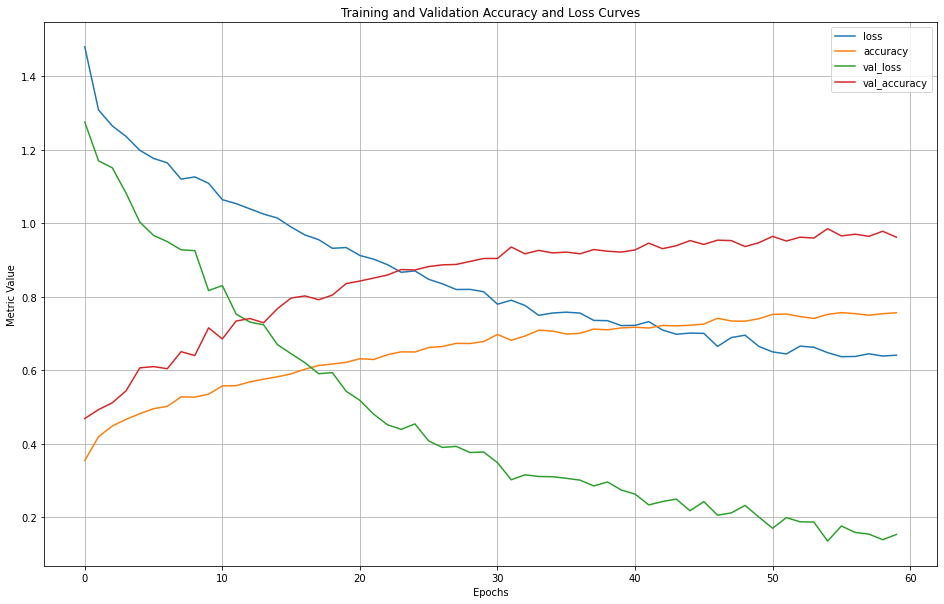

In [37]:
# Plot the accuracy and loss curves
history_df = pd.DataFrame(history.history)

history_df.plot(kind='line', figsize=(16, 10), grid=True, xlabel='Epochs', ylabel='Metric Value', title='Training and Validation Accuracy and Loss Curves')

### 6. Load test data and predict using the trained model

In [38]:
test_df = pd.read_csv('./data/test.tsv', sep='\t')
test_df.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [166]:
test_df.shape

(66292, 3)

In [39]:
# Remove duplicates
test_df.drop_duplicates(subset=['SentenceId'], inplace=True, keep='first')
test_df.shape

(3310, 3)

In [40]:
# Tokenize the phrases to create two input tensors for the model - input ids and attention masks
# test_tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
# MAX_SEQ_LEN = 50
def test_tokenize(text, max_len=MAX_SEQ_LEN):
    test_tokens = tokenizer.__call__(text, max_length=max_len, truncation=True, padding='max_length',  return_token_type_ids=False, add_special_tokens=True, return_tensors='tf')
    return test_tokens

In [41]:
sentiment_map = {0: 'negative', 1: 'somewhat negative', 2: 'neutral', 3: 'somewhat positive', 4: 'positive'}

In [219]:
# load the model
# from transformers import TFBertModel
# custom_objects = {'TFBertModel': TFBertModel}
# sentiment_model = tf.keras.models.load_model('./models/best_model.h5', custom_objects=custom_objects)

# sentiment_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 50)]         0           []                               
                                                                                                  
 tf_bert_model_4 (TFBertModel)  TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 50,                                            

In [51]:
test_df.head(1)['Phrase'].values[0]

'An intermittently pleasing but mostly routine effort .'

In [210]:
# Tokenize the phrases to create two input tensors for the model - input ids and attention masks
# tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
# MAX_SEQ_LEN = 50
# def tokenize(text, tokenizer=tokenizer, max_len=MAX_SEQ_LEN):
#     tokens = tokenizer.__call__(text, max_length=MAX_SEQ_LEN, padding='max_length', truncation=True, return_token_type_ids=False, add_special_tokens=True, return_tensors='tf')
#     return tokens

In [52]:
text = "This is a really good movie. I will recommend my friends to watch it."
test_tokens_1 = test_tokenize(test_df.head(1)['Phrase'].values[0], max_len=MAX_SEQ_LEN)
test_tokens_1
# pre_check = model.predict(tokenize(test_df.head(1)))
# print(f'{text} \n\n{pre_check}')
# print(f'Predicted sentiment: {sentiment_map[np.argmax(pre_check)]}')


{'input_ids': <tf.Tensor: shape=(1, 50), dtype=int32, numpy=
array([[  101,  1760, 27946,  1193, 16150,  4253,  1133,  2426,  9285,
         3098,   119,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]])>, 'attention_mask': <tf.Tensor: shape=(1, 50), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]])>}

In [48]:
test_tokens_1['input_ids'][0], test_tokens_1['attention_mask'][0]

(<tf.Tensor: shape=(50,), dtype=int32, numpy=
 array([  101,  1760, 27946,  1193, 16150,  4253,  1133,  2426,  9285,
         3098,   119,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])>,
 <tf.Tensor: shape=(50,), dtype=int32, numpy=
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])>)

In [53]:
# cast int32 tensors to float32
# test_tokens['input_ids'] = tf.cast(test_tokens['input_ids'], tf.float64)
# test_tokens['attention_mask'] = tf.cast(test_tokens['attention_mask'], tf.float64)
probabilities = model.predict([test_tokens_1['input_ids'], test_tokens_1['attention_mask']])
probabilities

1/1 [==============================] - 2s 2s/step


array([[1.3047827e-05, 4.3311052e-04, 5.2095093e-02, 9.3624800e-01,
        1.1210792e-02]], dtype=float32)

In [54]:
print(f'predicted sentiment: {sentiment_map[np.argmax(probabilities)]}')

predicted sentiment: somewhat positive


In [59]:
test_df['Sentiment'] = None

for i, row in test_df.iterrows():
    test_tokens = test_tokenize(row['Phrase'], max_len=MAX_SEQ_LEN)
    probabilities = model.predict([test_tokens['input_ids'], test_tokens['attention_mask']])
    test_df.loc[i, 'Sentiment'] = sentiment_map[np.argmax(probabilities)]

1/1 [==============================] - 0s 94ms/step


,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,An intermittently pleasing but mostly routine ...,somewhat positive
15,156076,8546,Kidman is really the only thing that 's worth ...,neutral
93,156154,8547,Once you get into its rhythm ... the movie bec...,somewhat positive
117,156178,8548,I kept wishing I was watching a documentary ab...,neutral
158,156219,8549,"Kinnear does n't aim for our sympathy , but ra...",somewhat negative


In [62]:
pd.set_option('display.max_colwidth', None)
test_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,An intermittently pleasing but mostly routine effort .,somewhat positive
15,156076,8546,"Kidman is really the only thing that 's worth watching in Birthday Girl , a film by the stage-trained Jez Butterworth -LRB- Mojo -RRB- that serves as yet another example of the sad decline of British comedies in the post-Full Monty world .",neutral
93,156154,8547,Once you get into its rhythm ... the movie becomes a heady experience .,somewhat positive
117,156178,8548,I kept wishing I was watching a documentary about the wartime Navajos and what they accomplished instead of all this specious Hollywood hoo-ha .,neutral
158,156219,8549,"Kinnear does n't aim for our sympathy , but rather delivers a performance of striking skill and depth .",somewhat negative


In [61]:
pd.set_option('display.max_colwidth', None)
test_df.tail()

,PhraseId,SentenceId,Phrase,Sentiment
66220,222281,11851,Not sweet enough to liven up its predictable story and will leave even fans of hip-hop sorely disappointed .,somewhat negative
66239,222300,11852,"Nasty , ugly , pointless and depressing , even if you hate clowns .",somewhat negative
66253,222314,11853,"With tightly organized efficiency , numerous flashbacks and a constant edge of tension , Miller 's film is one of 2002 's involvingly adult surprises .",positive
66280,222341,11854,They should have called it Gutterball .,somewhat negative
66287,222348,11855,"A long-winded , predictable scenario .",somewhat positive


In [ ]:
# Save the test dataframe to a csv file
test_df.to_csv('./data/test_results.csv', index=False)

In [ ]:
# Submit the results to Kaggle
api.competition_submit('./data/test_results.csv', 'Sentiment Analysis on Movie Reviews', 'Sentiment Analysis on Movie Reviews')

# Check the submission status
api.competitions_submissions_list('sentiment-analysis-on-movie-reviews')

